In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.5f}'.format
import matplotlib.pyplot as plt

# Venue polygon and shuttle points

In [2]:
# Create a polygon for event venue
from shapely.geometry import Polygon
import geopandas as gpd

lat_point_list = [30.131962, 30.146337, 30.140386, 30.122629]
lon_point_list = [-97.647388, -97.635686, -97.619652, -97.631465]
polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom])       
polygon['name']  = 'the Circuit of the Americas'
polygon
# polygon.explore()

,geometry,name
0,"POLYGON ((-97.64739 30.13196, -97.63569 30.14634, -97.61965 30.14039, -97.63147 30.12263, -97.64739 30.13196))",the Circuit of the Americas


In [3]:
import shapely.geometry as geom

# Create Shapely point geometries
point_waterloo_park = geom.Point(-97.736285, 30.273726) # (longitude, latitude)
point_barton_creek_square = geom.Point(-97.805046, 30.257509)
point_expo_center = geom.Point(-97.622544, 30.297062)
point_ridehailing = geom.Point(-97.614135, 30.178718)

point_shuttle_list = [point_waterloo_park,point_barton_creek_square,point_expo_center,point_ridehailing]
gdf_shuttle = gpd.GeoDataFrame({'Shuttle_Location': ['Shuttle_Waterloo_Park', 'Shuttle_Barton_Creek_Square', 'Shuttle_Expo_Center', 'Uber_DelValle_HighSchool'],
                        'geometry': point_shuttle_list},
                        crs="EPSG:4326")
gdf_shuttle

,Shuttle_Location,geometry
0,Shuttle_Waterloo_Park,POINT (-97.73628 30.27373)
1,Shuttle_Barton_Creek_Square,POINT (-97.80505 30.25751)
2,Shuttle_Expo_Center,POINT (-97.62254 30.29706)
3,Uber_DelValle_HighSchool,POINT (-97.61414 30.17872)


# This is all Austin INRIX traffic volume data
Downsamping data - takes 5min ish (only need to run once)

In [124]:
# %%time
# # 10.14, 10.15, 10.16 
# # 10.21, 10.22, 10.23
# # start_date, end_date = '2022-10-14 00:00:00','2022-10-16 23:59:59'
# start_date, end_date = '2022-10-21 00:00:00','2022-10-23 23:59:59'
# filtered_chunks = []

# # Read the CSV in chunks
# chunk_size = 100000  # Adjust the chunk size based on your memory capacity
# desire_frequency_min = '10T'

# for chunk in pd.read_csv("data/INRIX/Austin_20221/Austin_20221.csv", parse_dates=['measurement_tstamp'], chunksize=chunk_size):
# # for chunk in pd.read_csv("data/INRIX/Austin_20222/Austin_20222.csv", parse_dates=['measurement_tstamp'], chunksize=chunk_size):
#     # Filter the chunk by date range
#     filtered_chunk = chunk[(chunk['measurement_tstamp'] >= start_date) & (chunk['measurement_tstamp'] <= end_date)]
    
#     # Select only the first record in each 10-minute interval
#     downsampled_chunk = filtered_chunk[filtered_chunk['measurement_tstamp'].dt.floor(desire_frequency_min).diff() != '0T']

#     filtered_chunks.append(downsampled_chunk)
    
# # Concatenate all filtered chunks into a single DataFrame
# filtered_df = pd.concat(filtered_chunks)
# print(filtered_df.shape[0])

1923456
CPU times: user 4min 36s, sys: 51.7 s, total: 5min 28s
Wall time: 5min 33s


In [125]:
# # filtered_df[filtered_df['tmc_code']=='112P13033']
# print(filtered_df.shape[0])
# # filtered_df.to_csv('data/INRIX/austin_20221014_1016_10min_interval.csv',index=False)
# filtered_df.to_csv('data/INRIX/austin_20221021_1023_10min_interval.csv',index=False)

1923456


In [127]:
# df_traffic1 = pd.read_csv("data/INRIX/austin_20221021_1023_10min_interval.csv", sep=',', header=0)
# df_traffic2 = pd.read_csv("data/INRIX/austin_20221014_1016_10min_interval.csv", sep=',', header=0)
# combined_df = pd.concat([df_traffic1, df_traffic2], ignore_index=True)
# print(combined_df.shape[0])
# combined_df.to_csv('data/INRIX/austin_2022_GP_10min_interval.csv',index=False)

3846034


# Load road network information

In [4]:
df_road = pd.read_csv("data/partialdata/TMC_Identification.csv", sep=',', header=0)
df_road = df_road[['tmc','intersection','start_latitude','start_longitude','end_latitude','end_longitude','miles']]
df_road.head(3)

,tmc,intersection,start_latitude,start_longitude,end_latitude,end_longitude,miles
0,112+13140,US-183/E 7TH ST/AIRPORT BLVD/ED BLUESTEIN BLVD,30.25604,-97.70168,30.25218,-97.69594,0.43433
1,112+08908,FM-20,30.11066,-97.41049,30.11082,-97.37323,2.22783
2,112N06050,TX-304,30.10837,-97.33795,30.11119,-97.35797,1.23181


In [5]:
# !pip install folium matplotlib mapclassify

In [6]:
%%time
from shapely.geometry import LineString
from geopandas import GeoDataFrame

df_road['geometry'] = df_road.apply(
    lambda row: LineString([(row['start_longitude'], row['start_latitude']),
                             (row['end_longitude'], row['end_latitude'])]),
    axis=1
)

# Create a GeoDataFrame
gdf_road = GeoDataFrame(df_road, geometry='geometry',crs="EPSG:4326")

CPU times: user 33 ms, sys: 9.09 ms, total: 42.1 ms
Wall time: 39.9 ms


The data only contain major or primary road segments, might not observe minor roads

In [7]:
# show all the road segments in Austin
gdf_road.explore(
    legend=False
)

# Load traffic data

In [8]:
%%time
df_traffic = pd.read_csv("data/partialdata/Austin_20222.csv", sep=',', header=0)
print(df_traffic.shape[0])
df_traffic.head(3)

950396
CPU times: user 537 ms, sys: 83.8 ms, total: 620 ms
Wall time: 619 ms


In [9]:
df_traffic['Date'] = df_traffic['measurement_tstamp'].astype(str).str[0:10]
df_traffic['Date'] = pd.to_datetime(df_traffic['Date'], errors='coerce')
start_date, end_date = '2022-10-14','2022-10-16'
df_traffic_oneweekbefore = df_traffic[(df_traffic['Date']>=start_date)&(df_traffic['Date']<=end_date)]

In [10]:
%%time
df_traffic_merged = df_traffic.merge(df_road) #, left_on='tmc_code', right_on='tmc'
df_traffic_merged['travel_time_sec'] = df_traffic_merged['travel_time_minutes']*60
df_traffic_merged['measurement_tstamp'] = pd.to_datetime(df_traffic_merged['measurement_tstamp'])
df_traffic_merged['hour_min'] = df_traffic_merged['measurement_tstamp'].dt.strftime('%H:%M')
df_traffic_merged['delay'] = df_traffic_merged['travel_time_sec'] - df_traffic_merged['miles']/df_traffic_merged['historical_average_speed']*3600

CPU times: user 3.59 s, sys: 65.5 ms, total: 3.65 s
Wall time: 3.82 s


In [11]:
df_traffic_merged.loc[df_traffic_merged.delay <= 10, 'delay_level'] = 0
df_traffic_merged.loc[(df_traffic_merged.delay > 10)&(df_traffic_merged.delay <= 30), 'delay_level'] = 1
df_traffic_merged.loc[(df_traffic_merged.delay > 30)&(df_traffic_merged.delay <= 60), 'delay_level'] = 2
df_traffic_merged.loc[(df_traffic_merged.delay > 60)&(df_traffic_merged.delay <= 120), 'delay_level'] = 3
df_traffic_merged.loc[(df_traffic_merged.delay > 120)&(df_traffic_merged.delay <= 300), 'delay_level'] = 4
df_traffic_merged.loc[df_traffic_merged.delay > 300, 'delay_level'] = 5
df_traffic_merged.delay_level.value_counts()

# Very Low Congestion: delay <= 10 seconds
# Low Congestion: 10 < delay <= 30 seconds
# Moderate Congestion: 30 < delay <= 60 seconds
# High Congestion: 60 < delay <= 120 seconds
# Very High Congestion: 120 < delay <= 300 seconds
# Severe Congestion: delay > 300 seconds

0.00000    887621
1.00000    46544 
2.00000    8967  
3.00000    3364  
4.00000    2929  
5.00000    971   
Name: delay_level, dtype: int64

## Visualizing traffic congestion

In [12]:
gdf_road_merged = gdf_road.merge(df_traffic_merged[['tmc_code','Date','hour_min','delay','delay_level']], left_on='tmc', right_on='tmc_code')
print(gdf_road_merged.shape[0])
gdf_road_merged.head()

950396


,tmc,intersection,start_latitude,start_longitude,end_latitude,end_longitude,miles,geometry,tmc_code,Date,hour_min,delay,delay_level
0,112+13140,US-183/E 7TH ST/AIRPORT BLVD/ED BLUESTEIN BLVD,30.25604,-97.70168,30.25218,-97.69594,0.43433,"LINESTRING (-97.70168 30.25604, -97.69594 30.25218)",112+13140,2022-10-15,00:00,-3.27415,0.00000
1,112+13140,US-183/E 7TH ST/AIRPORT BLVD/ED BLUESTEIN BLVD,30.25604,-97.70168,30.25218,-97.69594,0.43433,"LINESTRING (-97.70168 30.25604, -97.69594 30.25218)",112+13140,2022-10-15,00:10,-3.87415,0.00000
2,112+13140,US-183/E 7TH ST/AIRPORT BLVD/ED BLUESTEIN BLVD,30.25604,-97.70168,30.25218,-97.69594,0.43433,"LINESTRING (-97.70168 30.25604, -97.69594 30.25218)",112+13140,2022-10-15,00:20,-5.07415,0.00000
3,112+13140,US-183/E 7TH ST/AIRPORT BLVD/ED BLUESTEIN BLVD,30.25604,-97.70168,30.25218,-97.69594,0.43433,"LINESTRING (-97.70168 30.25604, -97.69594 30.25218)",112+13140,2022-10-15,00:30,-2.07415,0.00000
4,112+13140,US-183/E 7TH ST/AIRPORT BLVD/ED BLUESTEIN BLVD,30.25604,-97.70168,30.25218,-97.69594,0.43433,"LINESTRING (-97.70168 30.25604, -97.69594 30.25218)",112+13140,2022-10-15,00:40,-5.07415,0.00000


In [13]:
# gdf_road_merged.to_csv('output/austin_2022_GP_10min_interval_withDelay_geodf.csv',index=False)

In [14]:
select_vis_date, select_hour_min = '2022-10-23', '12:00' # Friday
gdf_road_merged['Date'] = gdf_road_merged['Date'].astype(str)

In [15]:
# gdf_road_merged.delay_level.value_counts()

In [16]:
%%time
congestion_colors = ["#00FF00", "#ADFF2F", "#FFFF00", "#FFA500", "#FF0000", "#8B0000"]

m = gdf_road_merged[(gdf_road_merged['Date']==select_vis_date)&(gdf_road_merged['hour_min']==select_hour_min)].explore(
    column='delay_level',
    cmap= congestion_colors, #"rainbow",
    tiles="CartoDB dark_matter", # OpenStreetMap, CartoDB dark_matter
    categorical=True
)

m = gdf_shuttle.explore(
    m=m,
    markersize=40,
    linewidth=2,
    edgecolor="black",
)

CPU times: user 292 ms, sys: 43.8 ms, total: 336 ms
Wall time: 414 ms


In [17]:
%%time
polygon.explore(
    m=m
)

CPU times: user 11.9 ms, sys: 0 ns, total: 11.9 ms
Wall time: 10.8 ms


## Compute delay difference using the baseline as the same day from the last week
Using Saturdays as an example

In [18]:
%%time

df_diff_all = pd.DataFrame()

for day_pair in [['2022-10-14','2022-10-21'],['2022-10-15','2022-10-22'],['2022-10-16','2022-10-23']]:
    day1, day2 = day_pair[0],day_pair[1]
    print(day1, day2)
    
    df_baseline = df_traffic_merged[df_traffic_merged['Date']==day1].sort_values(by=['tmc_code','measurement_tstamp'], ascending=True)
    
    df_focus = df_traffic_merged[df_traffic_merged['Date']==day2].sort_values(by=['tmc_code','measurement_tstamp'], ascending=True)
    
    print(df_baseline.shape[0], df_focus.shape[0])

    df_diff = pd.merge(
        df_baseline[['tmc_code', 'hour_min','delay']],
        df_focus[['tmc_code','hour_min', 'delay']],
        on=['tmc_code','hour_min'],
        suffixes=('_baseline', '_focus')
    )
    
    # Calculate the delay difference
    df_diff['delay_difference'] = df_diff['delay_focus'] - df_diff['delay_baseline']
    
    df_diff['date'] = day2

    df_diff_all = pd.concat([df_diff_all, df_diff], ignore_index=True)

2022-10-14 2022-10-21
0 63360
2022-10-15 2022-10-22
63360 63360
2022-10-16 2022-10-23
63360 63360
CPU times: user 212 ms, sys: 3.45 ms, total: 216 ms
Wall time: 250 ms


In [19]:
# df_diff_all.to_csv('output/austin_2022_GP_10min_interval_delaydifference.csv',index=False)
# df_diff_all.date.value_counts()

## Plot average delay time for the whole Austin network and compare with the average delay from the same day last week

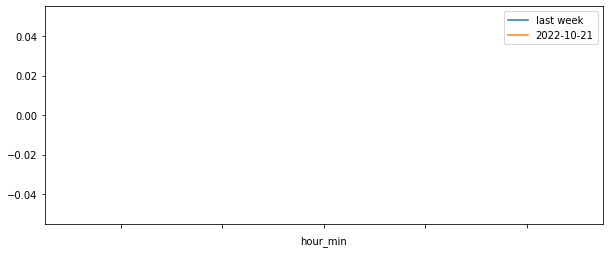

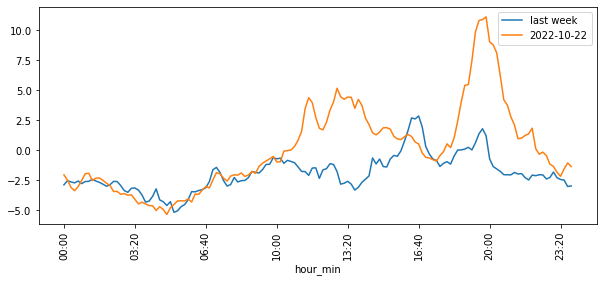

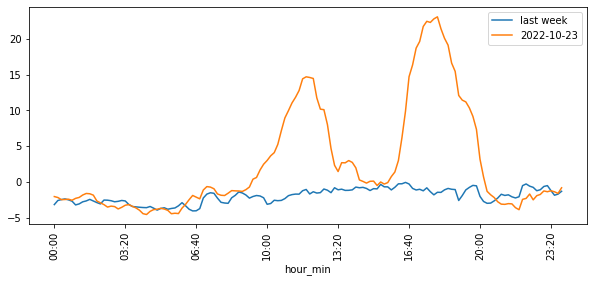

In [20]:
def plot_delay_baseline(df,date):
    fig, ax = plt.subplots(1, figsize=(10, 4))
    df_select = df[df['date']==date]
    df_select.groupby('hour_min').delay_baseline.mean().plot(ax=ax,label='last week')
    df_select.groupby('hour_min').delay_focus.mean().plot(ax=ax,label=date)
    plt.xticks(rotation=90)
#     plt.title(date)
    plt.legend()
    plt.show()
    
plot_delay_baseline(df_diff_all,'2022-10-21')
plot_delay_baseline(df_diff_all,'2022-10-22')
plot_delay_baseline(df_diff_all,'2022-10-23')

## Average delay difference for the whole network (current day delay - last week same day delay)

count   640800.00000
mean    0.01701     
std     13.90367    
min     -718.20000  
25%     -1.80000    
50%     0.00000     
75%     1.80000     
max     1009.20000  
Name: delay_difference, dtype: float64


<AxesSubplot:>

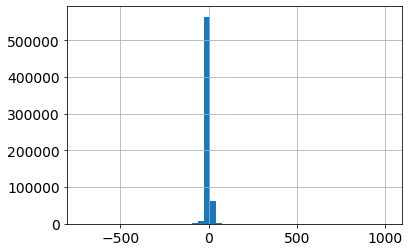

In [164]:
selectOneDate = '2022-10-22' # Saturday
df_diff_select = df_diff_all[df_diff_all['date']==selectOneDate]
plt.rcParams.update({'font.size': 14})
print(df_diff_select.delay_difference.describe())
df_diff_select.delay_difference.hist(bins=50)

In [140]:
import matplotlib.dates as mdates


def plot_delay_diff_oneday(df, date):
    
    plt.rcParams.update({'font.size': 14})
    
    df_diff_select = df[df['date']==date]

    df_diff_new = df_diff_select.groupby('hour_min').delay_difference.mean().reset_index()

    df_diff_new['hour_min'] = pd.to_datetime(df_diff_new['hour_min'], format='%H:%M')

    # Plotting the time series
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot the time series
    ax.plot(df_diff_new['hour_min'], df_diff_new['delay_difference'],label='Average Delay Difference')

    # Formatting the x-axis to show hours and minutes
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Adjust interval as needed

    plt.xticks(rotation=90)
    plt.title('Average Delay Difference Over Time (' + date +  ')')
    plt.xlabel('Time (HH:MM)')
    plt.ylabel('Average Delay Difference (seconds)')
    # plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

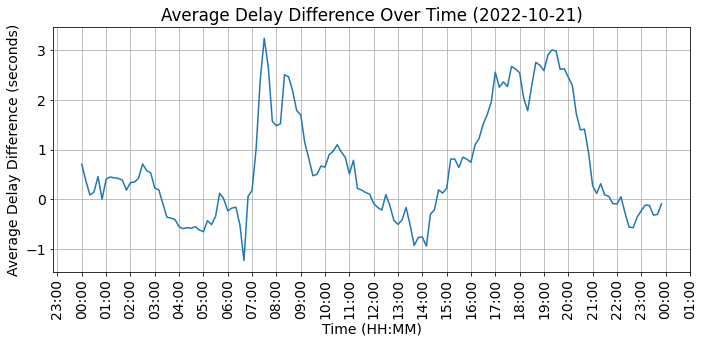

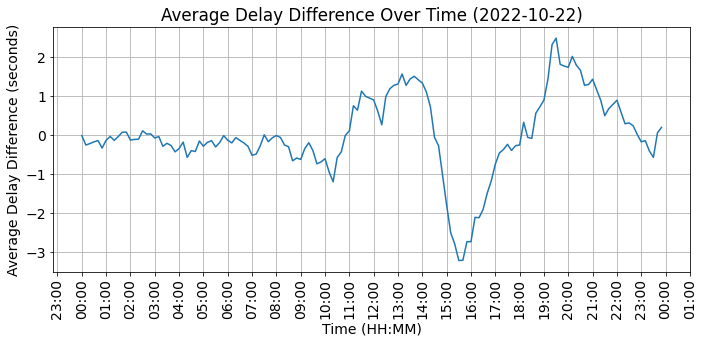

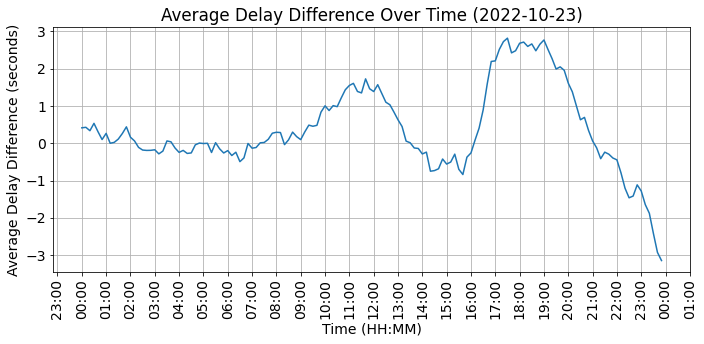

In [144]:
plot_delay_diff_oneday(df_diff_all, '2022-10-21') # Friday 
plot_delay_diff_oneday(df_diff_all, '2022-10-22') # Saturday 
plot_delay_diff_oneday(df_diff_all, '2022-10-23') # Sunday 

In [152]:
df_diff_all.head()

,tmc_code,hour_min,delay_baseline,delay_focus,delay_difference,date
0,112+04758,00:00,-0.93268,-0.93268,0.00000,2022-10-21
1,112+04758,00:10,-0.93268,-0.93268,0.00000,2022-10-21
2,112+04758,00:20,-0.33268,-0.93268,-0.60000,2022-10-21
3,112+04758,00:30,-0.93268,-0.93268,0.00000,2022-10-21
4,112+04758,00:40,-0.93268,-0.93268,0.00000,2022-10-21
